<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias_ngrams_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster, single, complete, average
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 2 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [ ]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [3]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [4]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(28122, 3)


In [5]:
dfDados = dfDados.sample(frac=0.05)
print(dfDados.shape)

(1406, 3)


In [ ]:
dfDados.columns

Index(['text', 'category', 'category_nro'], dtype='object')

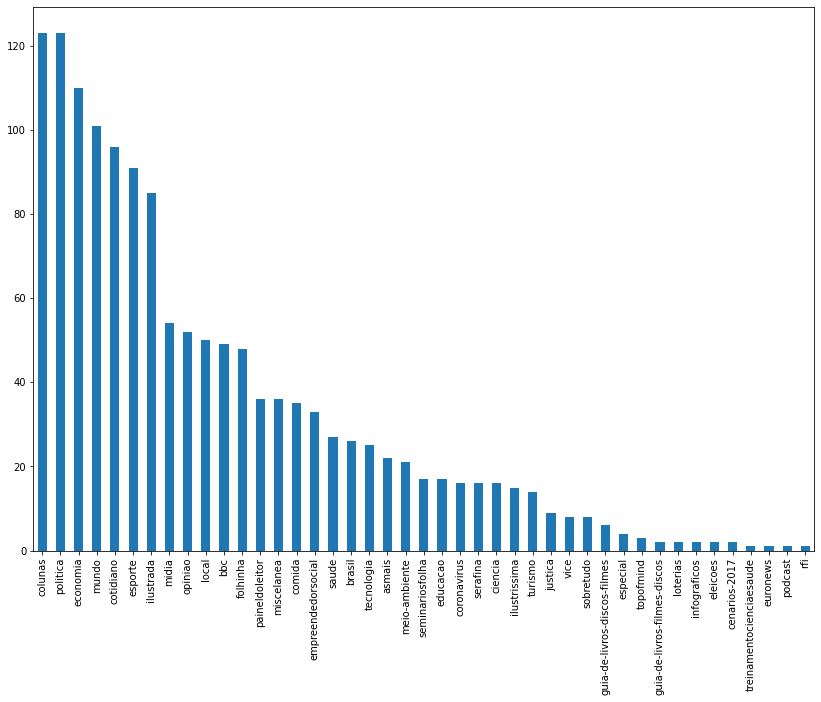

In [ ]:
df = dfDados['category'].value_counts()
#df =df.head(40)
df.plot.bar(figsize=(14,10))


In [6]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data]   Unzipping stemmers/rslp.zip.
CPU times: user 155 ms, sys: 88.5 ms, total: 243 ms
Wall time: 22.6 s


In [7]:
print(dfPreProc.shape)
dfPreProc.head()

(1406, 3)


,text,category,category_nro
19549,espetácul pront ent talv interrompêl esper aconteç avis doming arian mnouchkin moment ant segund ensai abert une chambr en ind quart índ recent espetácul théâtr du soleil aí tud norm prim dev ser últ estre inform fam trup teatr franc acontec seman dat prev dire dand ord elenc mei públic diret mes posicion centr fil h entant desd mont anteri macbeth estre abril sabes bem paril franç mesm conhec repertóri engaj sinton atual soleil pod ter escolh quart índ cen nov peç angúst incompre person cen vêm princip context póscharli hebd novembr enred febril limítrof sonh pesadel real grup teatr encontr vilarej indi busc inspir próx projet temp vivenc dist lut atent franç cas art imit vid pouc temp atent fim mnouchkin coleg conceb coletiv text part improvisaç dur tempor escol nômad soleil puducherry cidad sul índ país hav aliment imagin companh espetácul tragicôm newslett soleil public mes atrás mnouchkin hav indic tom vir coraj bel faz públic rir med fil entr teatr demor control seguranç consegu arranc sorris tod pel engraç polic indi peç at inspecion bols person princip líd trup fictíc dire enlouquec cornél delíri algum aterroriz outr cômic tortur jihad encontr vis shakespe tchékhov aconselh construç nov espetácul bard segred trabalh incondic import obstácul ah zomb malv complet une chambr en ind content caço vil trunf autoderris galhof relaç univers teatr evid cen atriz pe dúv talent pod ser grand intérpret vid dram tod teatr mund demol alguém sent falt quant temp pergunt mei caminh cornél públic riu emocionous aplaud long luz acend pergunt respond mnouchkin fez pequen alteraç peç estre ofic ensai precis ser interromp merc editor vésp aniversári ano ataqu terror dia pratel livr ench testemunh obr oferec divers pont vist sobr experi traumá aind long cicatr médic unidad elit políci nacion franc médecin du raid vivr en état durgenc mathi langloil pass don restaurant la bell équip ond pesso morr une bell équip grégory reibenberg relat tern pai perd filh bataclan lindicibl z georg salin sal concert reabr sáb show sting bataclan quadr relat fort fred dewild pseudôn ilustr especi anatom lev leit olh furacã letr anunci show band eagl of death metal aparec prim págin histór quadr mon bataclan lemieux dal di dewild relembr dua hor pass deit chã fing est mort bolh human salv plen cao convers toc mão jov sobreviv precis tir cabeç film repet cont hq atir represent esquelet isabel junc jornal,ilustrissima,15
16329,mudanç fragiliz direit infl fenômen se econôm dentr outr mal corró pod aquisi assalari esf juríd infl legisl prejudic poi utiliz arcabouç teór panace resoluç mal soc result aument ineficác avolum dist normat factic direit eleitor infeliz fenômen infl legisl const aparec form casuís norm ano préeleitor lei n realiz minirreform fug regr nov legisl propost afã densific conex princípi norte vid cidadã surg aplac inter controvers possível contribu fragil direit eleitor ciênc juríd desenvolv jurisprudenci imped consolid teor princip mácul pod diz avanç torn obrigatór realiz nov eleiç decis judic indefer registr cass diplom import perd mandat candidat eleit pleit majorit todav balanç geral satisfatóri contr reduzius temp campanh clar acint padr regim democrá iníci plenitud períod eleitor ant começ dia julh pass ser permit agost vincul propagand gratuit rádi tv pass dia dia assim impos tod ped registr julg inst ordinár dia ant ele configur irre juríd dign alien exacerb práxil eleitor tom palavr alien sent distanc real esquizofren eleitor limit exacerbad gast municípi mil elei ness cas cad campanh prefeit pod gast r mil vere r mil tod sab val reflet real forç vári candidat condut ileg result cômic trág ilicitud imping ra est necess eleitor outr paradox apresent lei reduç temp campanh eleitor retirous pun condut irregul précampanh torn fas import etap eleitor típic debilitous assim complet conceit propagand antecip agor confin exclusiv ped explícit vot limit literal portant reform realiz pod ser carater sent mantém 

In [ ]:
#dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv',index=False)
#dfPreProc = pd.read_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')
#dfPreProc['text'] = dfPreProc['text'].astype('unicode')

In [8]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.9, ngrams=(1,3))
X_tfidf = retornaMatriztfIdf(V)

In [9]:
%%time
#https://www.kaggle.com/tchainzzz/agglomerative-document-clustering-on-cord-19

dist = 1 - cosine_similarity(X_tfidf)
dist = dist - dist.min()
linkage_matrix = average(dist) #ward(dist)

CPU times: user 1.46 s, sys: 465 µs, total: 1.46 s
Wall time: 1.45 s


* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [ ]:
#X = np.ones((X_tfidf.shape))
#X_tfidf.toarray(out=X)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03433457, 0.01992446,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03860407,
        0.        ]])

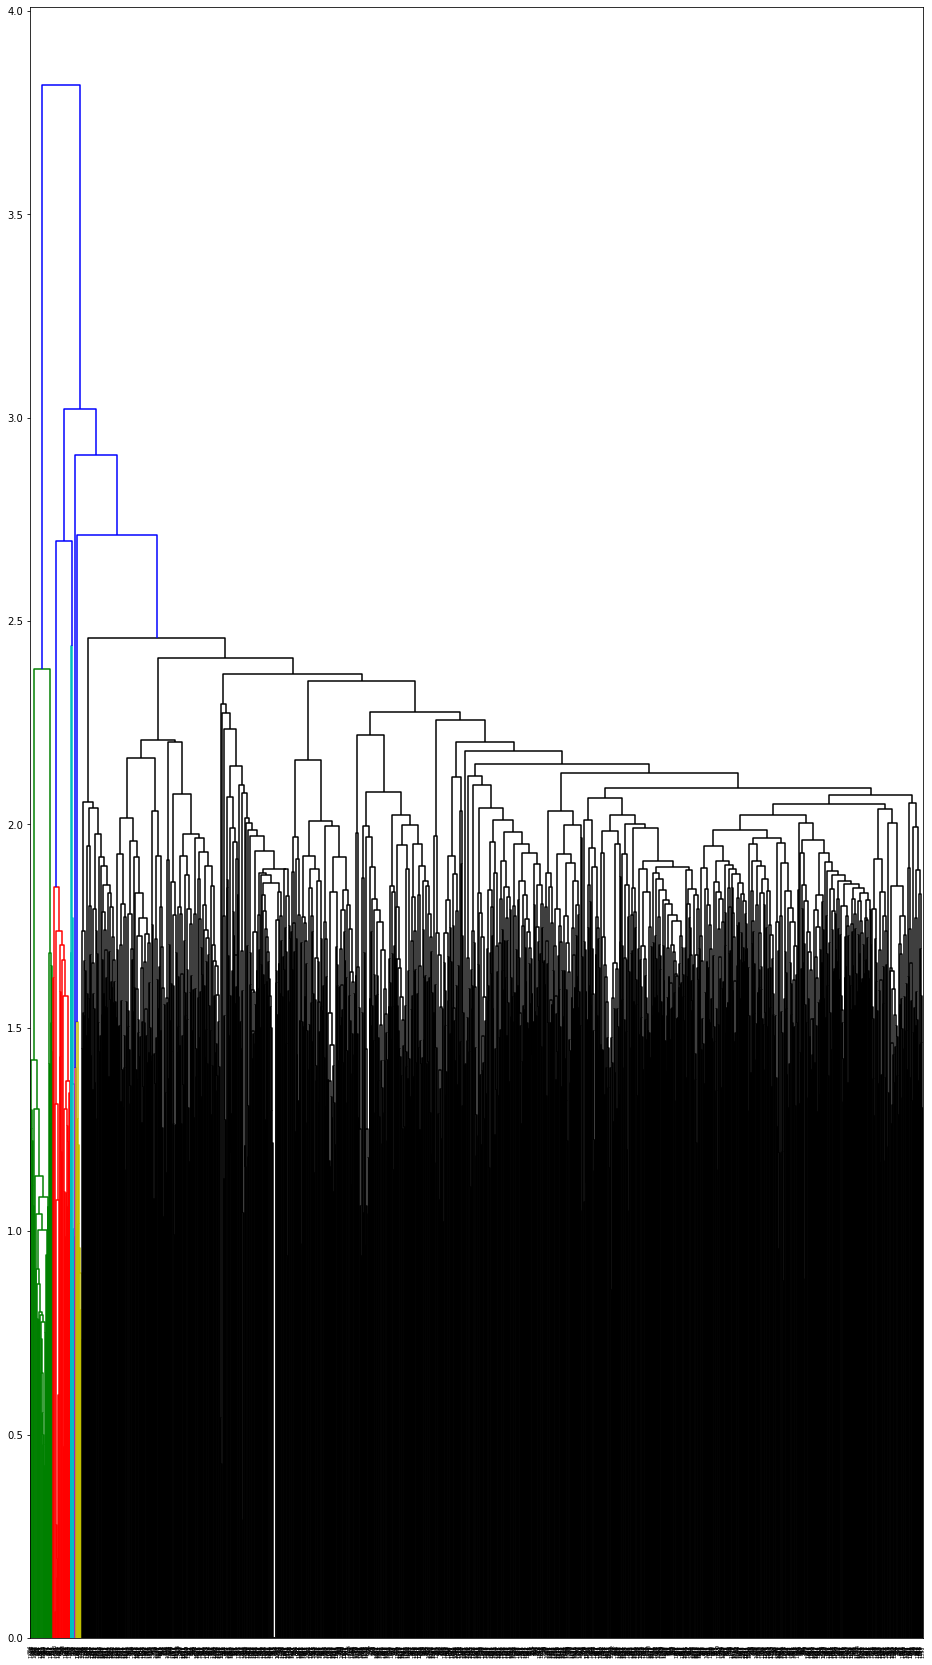

CPU times: user 34.4 s, sys: 3.02 s, total: 37.5 s
Wall time: 36.1 s


In [10]:
%%time
plt.figure(figsize=(16, 30))
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

In [ ]:
def aplicaModelo(model, dfDados, X_tfidf):
  dfDadosPred = dfDados.copy()
  y_pred = model.fit_predict(X_tfidf.toarray())
  dfDadosPred['y_pred'] = y_pred
  print(dfDadosPred['y_pred'].value_counts())
  return dfDadosPred

Similaridade Coseno

In [49]:
X_cosine = X_tfidf.toarray()
print(np.where(~X_cosine.any(axis=1))[0])
z = np.where(~X_cosine.any(axis=1))[0]
for i in z:
  X_cosine[i] = np.ones(X_cosine[i].shape)*1/100
print(np.where(~X_cosine.any(axis=1))[0])

[ 368  413  813  964 1388]
[]


Para 6 clusters

In [50]:
#model= AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average')
#dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)
model= AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average')
y_pred = model.fit_predict(X_cosine)

<BarContainer object of 6 artists>

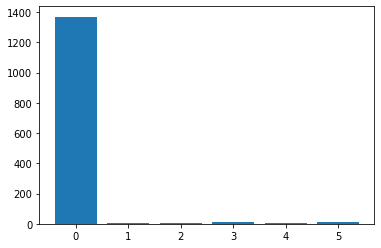

In [51]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


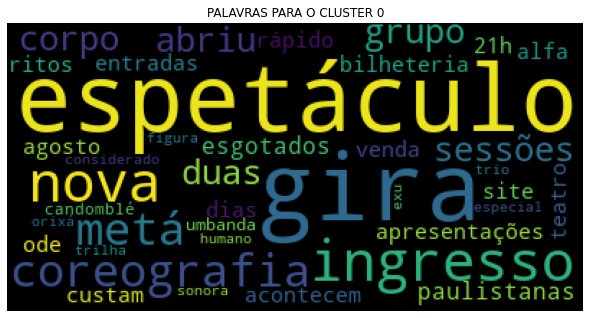

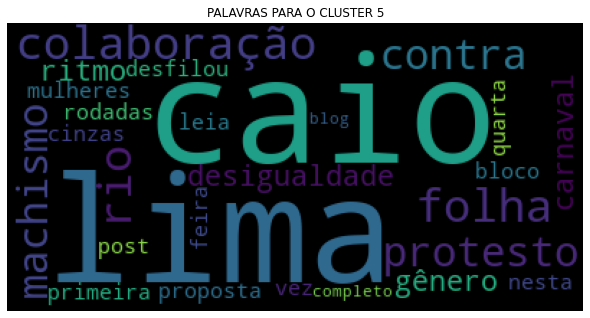

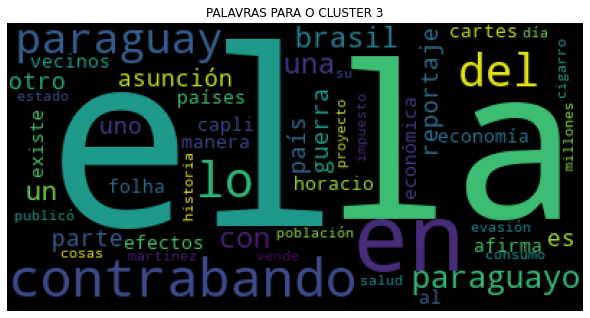

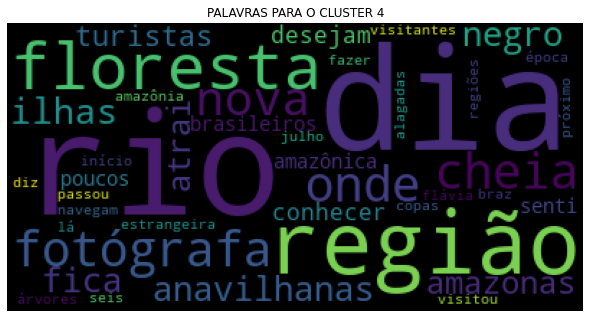

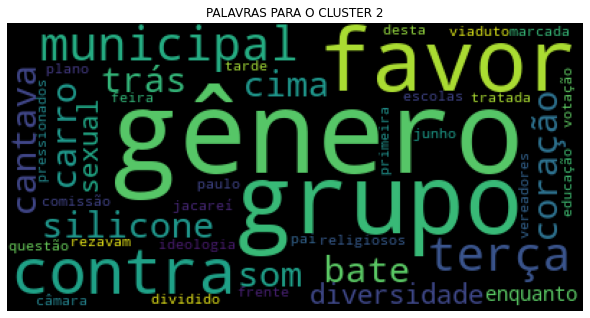

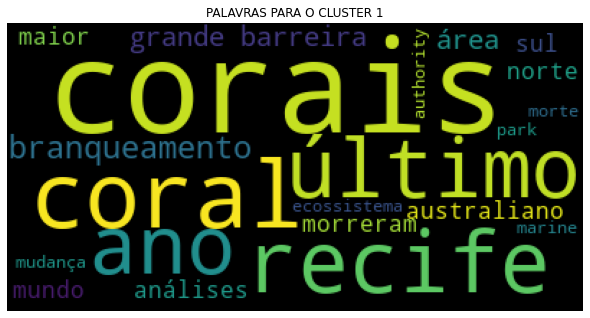

In [52]:
dfconta = dfDados['y_pred'].value_counts().reset_index()
sw = nltk.corpus.stopwords.words('portuguese')
for y in dfconta['index'].tolist():
  dftmp = dfDados.loc[:,['text']][dfDados['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),200,str(y),sw)

Para 12 Clusters

In [44]:
model= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
y_pred = model.fit_predict(X_cosine)

<BarContainer object of 12 artists>

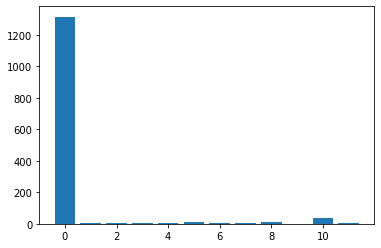

In [45]:
dfDados['y_pred'] = y_pred
dfconta = dfDados.groupby(y_pred)['category_nro'].count().reset_index().rename(columns={'index':'y_pred','category_nro':'qtd'}).sort_values(by='qtd', ascending=False)
plt.bar('y_pred','qtd',data=dfconta)


In [40]:
dfDados[dfDados['y_pred']==0][['category','y_pred']].groupby('category').count().reset_index().rename(columns={'y_pred':'qtd'}).sort_values(by='qtd', ascending=False)

,category,qtd
6,colunas,114
33,politica,112
11,economia,101
29,mundo,93
20,ilustrada,93
16,esporte,90
10,cotidiano,83
24,local,56
26,midia,50
18,folhinha,46


In [39]:
dfDados[dfDados['y_pred']==0].sample(10)

text  ... y_pred
8109                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           